# Tutorial: an example risk assessment

Ref: https://climada-python.readthedocs.io/en/stable/tutorial/1_main_climada.html

## Hazard Module

### 1. Storm Tracks

d:\Anaconda3\envs\climada_env\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
IBTrACS.ALL.v04r00.nc: 26.8MB [00:42, 623kB/s]                               


2023-12-04 11:08:38,764 - climada.hazard.tc_tracks - WARNING - 1118 storm events are discarded because no valid wind/pressure values have been found: 1851175N26270, 1851181N19275, 1851187N22262, 1851192N12300, 1851214N14321, ...
2023-12-04 11:08:38,777 - climada.hazard.tc_tracks - WARNING - 140 storm events are discarded because only one valid timestep has been found: 1852232N21293, 1853242N12336, 1855236N12304, 1856221N25277, 1856235N13302, ...


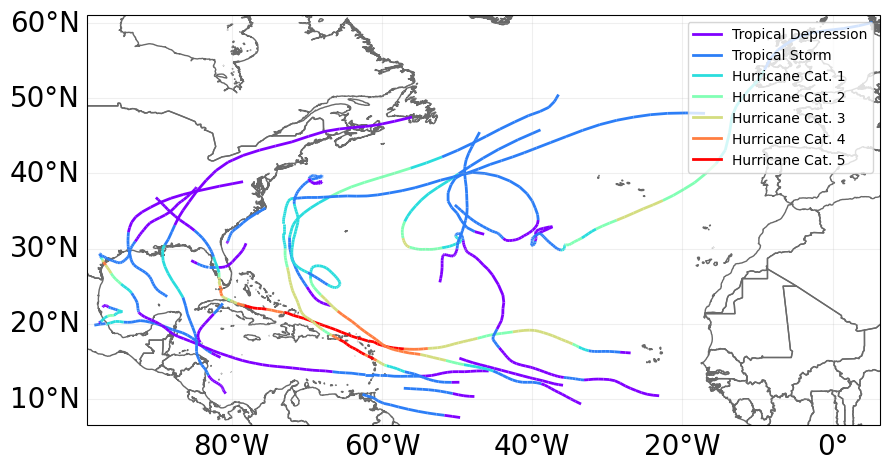

In [1]:
import numpy as np
from climada.hazard import TCTracks
import warnings # To hide the warnings
warnings.filterwarnings('ignore')

tracks = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA')

tracks_2017 = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA', year_range = (2017, 2017))
tracks_2017 .plot();

tracks.equal_timestep(time_step_h=0.5)

### 2. Centroids

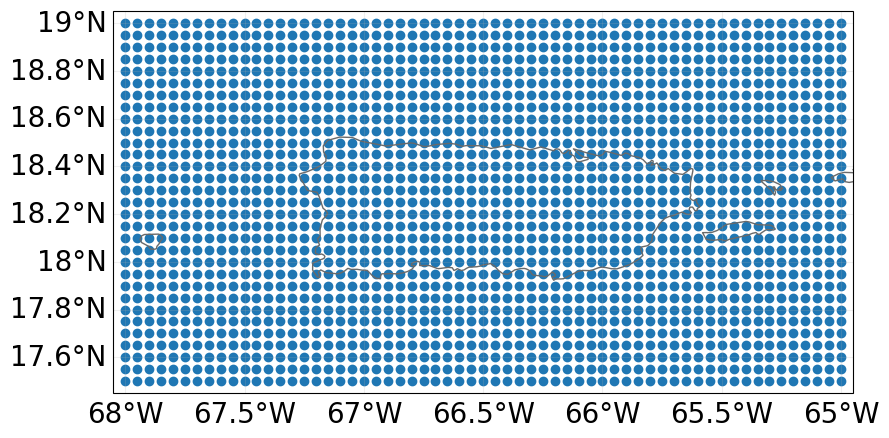

In [2]:
from climada.hazard import Centroids

min_lat, max_lat, min_lon, max_lon = 17.5, 19.0, -68.0, -65.0
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.05)
cent.check()
cent.plot();


### 3. Hazard Footprint

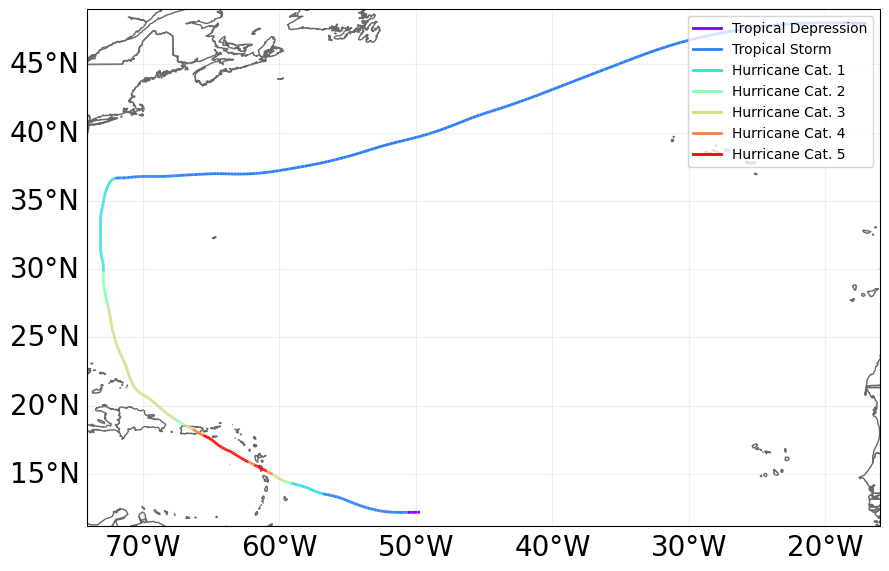

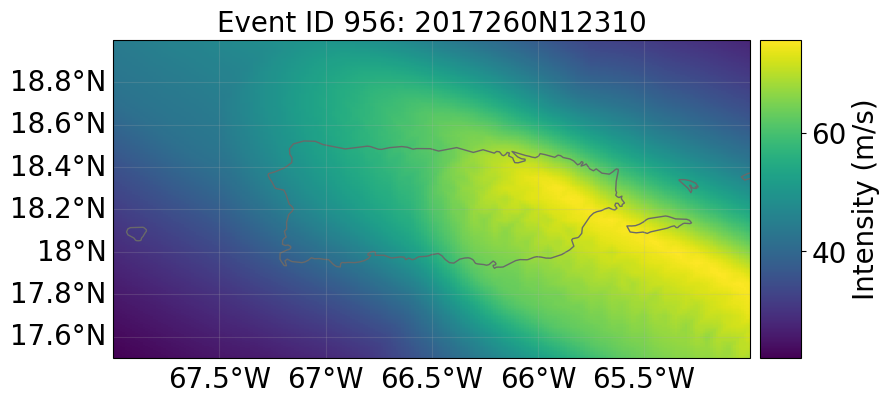

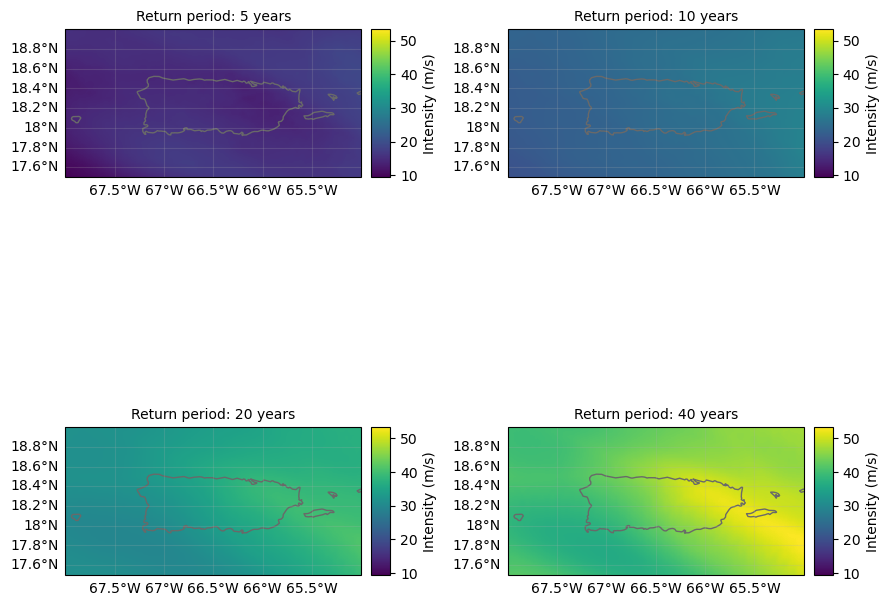

In [3]:
from climada.hazard import TropCyclone

haz = TropCyclone.from_tracks(tracks, centroids=cent)
haz.check()

tracks.subset({"sid": "2017260N12310"}).plot();  # This is how we subset a TCTracks object

haz.plot_intensity(event='2017260N12310');
haz.plot_rp_intensity(return_periods=(5,10,20,40));

## Entity Module

### 4. Entity's Exposures

26.8kKB [00:30, 874KB/s]                             

2023-12-04 11:13:08,885 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020


2023-12-04 11:13:08,920 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-12-04 11:13:08,980 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020


1.44kKB [00:05, 258KB/s]                           

2023-12-04 11:13:18,063 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead


2023-12-04 11:13:19,796 - climada.util.finance - WARNING - No data for country, using mean factor.


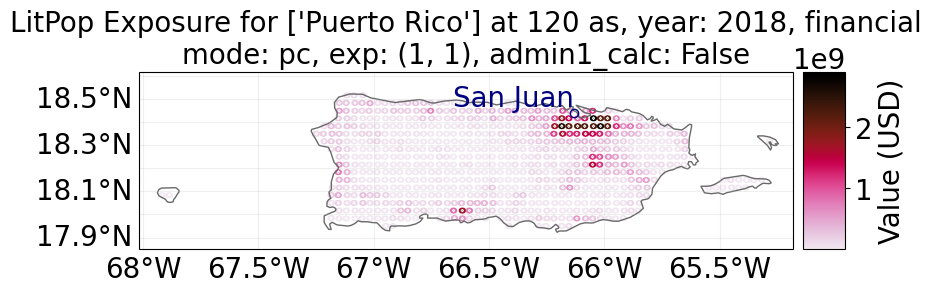

In [5]:
from climada.entity.exposures import LitPop

exp_litpop = LitPop.from_countries('Puerto Rico', res_arcsec = 120)  # We'll go lower resolution than default to keep it simple
exp_litpop.set_geometry_points() # Set geodataframe geometries from lat lon data

exp_litpop.plot_hexbin(pop_name=True, linewidth=4, buffer=0.1);

### 5. Impact Function

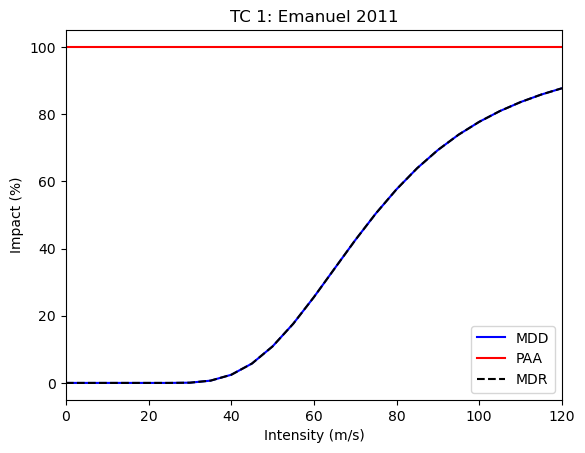

In [6]:
from climada.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone

imp_fun = ImpfTropCyclone.from_emanuel_usa()
imp_fun.plot();

imp_fun_set = ImpactFuncSet([imp_fun])

exp_litpop.gdf['impf_TC'] = 1

### 6. Adaptation Measures

Text(0.5, 1.0, 'TC: Modified impact function')

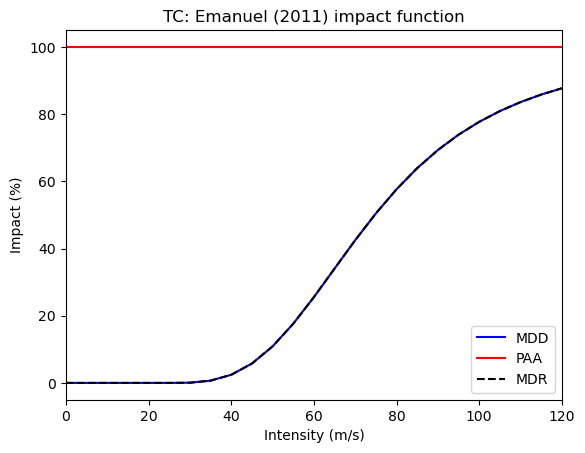

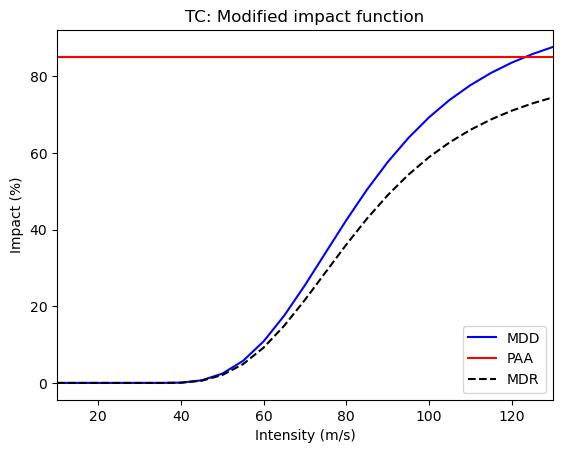

In [7]:
from climada.entity import Measure, MeasureSet

meas_mangrove = Measure(
    name='Mangrove',
    haz_type='TC',
    color_rgb=np.array([0.2, 0.2, 0.7]),
    cost=500000000,
    mdd_impact=(1, 0),
    paa_impact=(1, -0.15),
    hazard_inten_imp=(1, -10),
)

meas_set = MeasureSet(measure_list=[meas_mangrove])
meas_set.check()

mangrove_exp, mangrove_imp_fun_set, mangrove_haz = meas_mangrove.apply(exp_litpop, imp_fun_set, haz)
axes1 = imp_fun_set.plot()
axes1.set_title('TC: Emanuel (2011) impact function')
axes2 = mangrove_imp_fun_set.plot()
axes2.set_title('TC: Modified impact function')

2023-12-04 11:13:37,581 - climada.hazard.base - WARNING - Exceedance intenstiy values below 0 are set to 0.                    Reason: no negative intensity values were found in hazard.


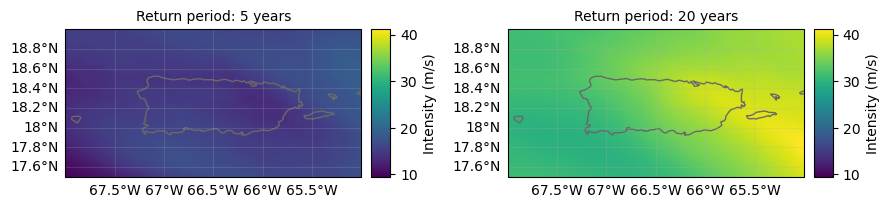

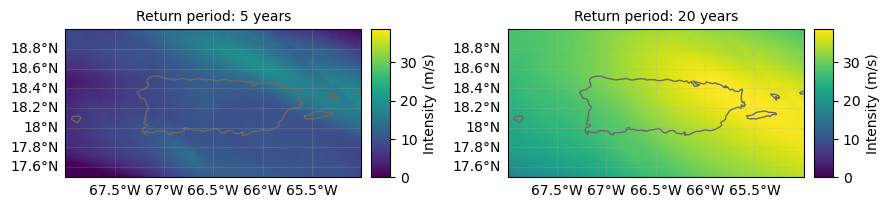

In [8]:
meas_buildings = Measure(
    name='Building code',
    haz_type='TC',
    color_rgb=np.array([0.2, 0.7, 0.5]),
    cost=100000000,
    hazard_freq_cutoff=0.1,
)

meas_set.append(meas_buildings)
meas_set.check()

buildings_exp, buildings_imp_fun_set, buildings_haz = meas_buildings.apply(exp_litpop, imp_fun_set, haz)

haz.plot_rp_intensity(return_periods=(5, 20));
buildings_haz.plot_rp_intensity(return_periods=(5, 20));

### 7. Discount Rates

<Axes: title={'center': 'Discount rates'}, xlabel='Year', ylabel='discount rate (%)'>

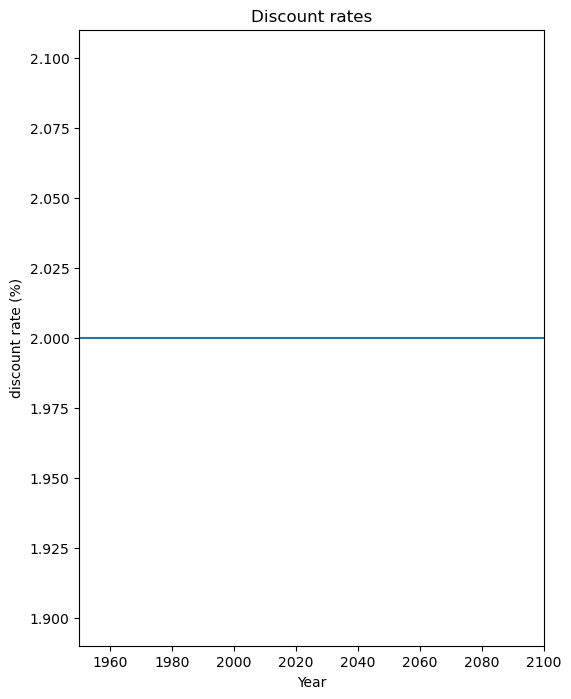

In [9]:
from climada.entity import DiscRates

years=np.arange(1950, 2101)
rates=np.ones(years.size) * 0.02
disc = DiscRates(years=years, rates=rates)
disc.check()
disc.plot()

### 8. Define Entity

In [10]:
from climada.entity import Entity

ent = Entity(
    exposures=exp_litpop,
    disc_rates=disc,
    impact_func_set=imp_fun_set,
    measure_set=meas_set
)

## Engine Module

### 9. Impact

Expected average annual impact: 9.414e+08 USD


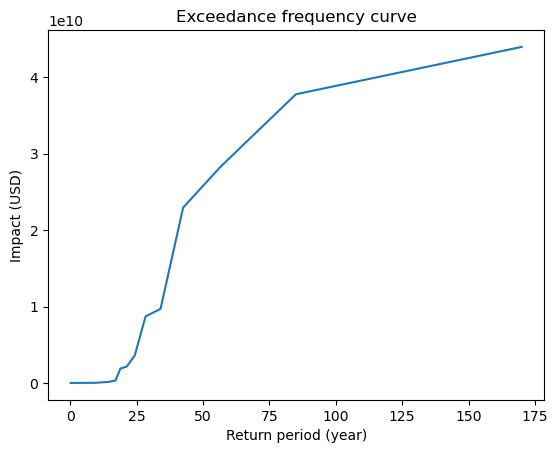

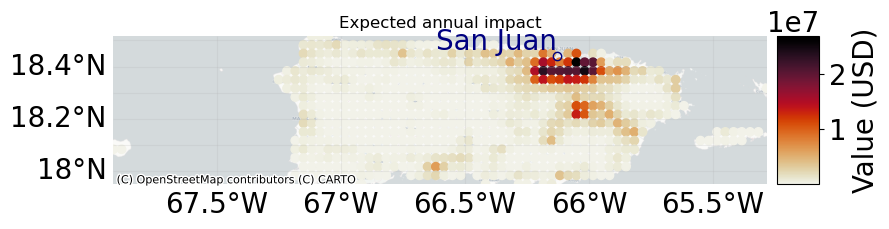

In [12]:
from climada.engine import ImpactCalc

imp = ImpactCalc(ent.exposures, ent.impact_funcs, haz).impact()

freq_curve = imp.calc_freq_curve() # impact exceedance frequency curve
freq_curve.plot();

print('Expected average annual impact: {:.3e} USD'.format(imp.aai_agg))

imp.plot_basemap_eai_exposure(buffer=0.1); # average annual impact at each exposure